<font size="6">Fractional Processes & Kernel Spectral Density</font>

The goal of this notebook is to make a maximum likelihood estimator that takes into account the auto-correlation of the data, not just mean and variance. 

Even if two sets of data have the same distributional parameters the ordering for the data may still not be the same (i.e the precise nature of auto-correlation decay in the time domain). Processes with long memory or periodic memory will not be ergodic especially if the auto-correlation decay is slow and follows a power law. 

In [14]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

In [29]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 4

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [30]:
m6 = pd.read_csv('./data/assets.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Z-Scoring & Auto-Correlation Decay Plots</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). Z-scored measurements of the log price for each asset based on a rolling window. At timepoint 't' the window looks back 'w' steps to calculate mu and sigma. 

$$\huge z_t = \frac{x_t - \mu_{t-w:t}}{\sigma_{t-w:t}}$$

There are regions where the current log price is either above or below its running average (as measured in units of standard deviation) and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. <b>It is important that the running average never takes into account future data which would introduce lookahead bias, so a rolling metric based on the list comprehension is used.</b> 

(Hurst Exponent Auto-Covariance Function) 
<center>$\huge cov(s,t) = \frac{1}{2} \left( t^{2H} + s^{2H} - |t-s|^{2H} \right)$</center>

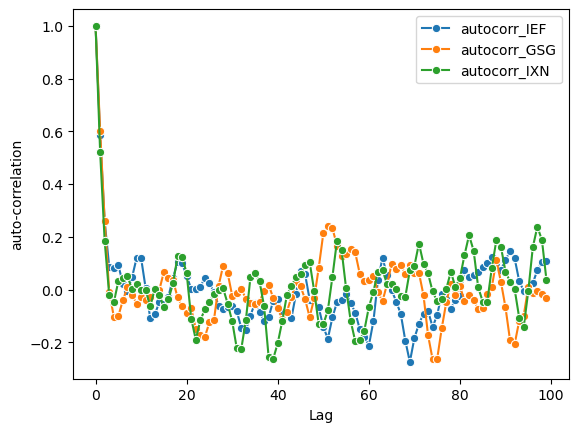

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-gwthkup5
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-gwthkup5
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


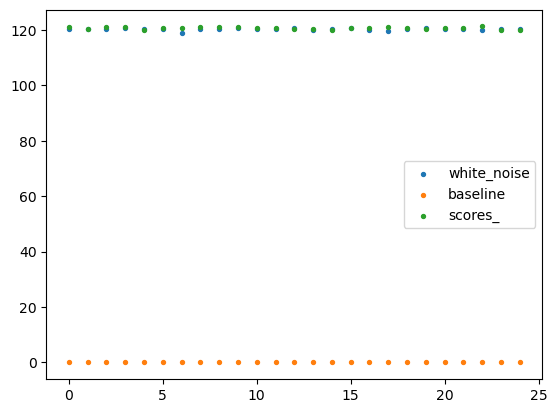

In [31]:
import scipy.stats as stats
import scipy 

m6_subset1 = m6_assets.copy()

# Window length 5 days
wlen = 5

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply z-score in a rolling way that does not create lookahead bias 
rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = rolling_zscore(m6_subset1['IEF'])
m6_subset['GSG'] = rolling_zscore(m6_subset1['GSG'])
m6_subset['IXN'] = rolling_zscore(m6_subset1['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 100)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 100)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 100)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

%pip install torch
%pip install gpytorch
%pip install git+https://github.com/forrestbao/pyeeg.git
import torch
import gpytorch
import pyeeg

class FractionalPSD:
    def __init__(self, data):
        self.data = np.array(data)

    def distance_norm(self, target): 
        x1 = torch.tensor([ _x for _x in target ], dtype=torch.float)
        x0 = torch.tensor([ _x for _x in self.data  ], dtype=torch.float)
        
        # Evaluate kernel auto-covariance matrix 
        kernel = gpytorch.kernels.RBFKernel()
        autocov_1 = (kernel(x1).evaluate()).detach().numpy() 
        autocov_0 = (kernel(x0).evaluate()).detach().numpy()
        self.autocov = autocov_0
        
        #import seaborn as sns 
        #import matplotlib.pyplot as plt
        #sns.lineplot(data=x1)
        #sns.lineplot(data=x0, label='x0')
        #plt.legend()
        #plt.show()
        
        # Plot the evaluation results
        #import matplotlib.pyplot as plt 
        #fig, ax = plt.subplots(2)
        #im0= ax[0].imshow(autocov_0, cmap='viridis', origin='lower')
        #im1= ax[1].imshow(autocov_1, cmap='viridis', origin='lower')

        # Add colorbar
        #cbar0 = ax[0].figure.colorbar(im0, ax=ax[0])
        #cbar1 = ax[1].figure.colorbar(im1, ax=ax[1])    

        # Show the plot
        #plt.grid(False)
        #plt.show()

        # Frobius distance 
        return np.linalg.norm(autocov_1 - autocov_0, 'fro') 
    
# Example 

data = m6_subset['GSG'].values
fractional_psd = FractionalPSD(data)
scores_base=[]
scores_=[]
scores=[]
hursts=[]

iters=25
for i in range(iters): 
    white_noise = torch.normal(np.mean(fractional_psd.data), np.var(fractional_psd.data), size=(len(m6_subset),))
    white_noise = white_noise.detach().numpy()
    score = fractional_psd.distance_norm(white_noise)  
    scores.append(score)
    hursts.append(pyeeg.hurst(white_noise))
    
for i in range(iters): 
    white_noise = torch.normal(0, np.var(fractional_psd.data) * 2, size=(len(m6_subset),))
    white_noise = white_noise.detach().numpy()
    score = fractional_psd.distance_norm(white_noise)  
    scores_.append(score)

for i in range(iters): 
    score = fractional_psd.distance_norm(fractional_psd.data)  
    scores_base.append(score)

plt.scatter(x=range(len(scores)), y=scores, s=8, label='white_noise')
plt.scatter(x=range(len(scores_base)), y=scores_base, s=8, label='baseline')
plt.scatter(x=range(len(scores_)), y=scores_, s=8, label='scores_')
plt.legend()
plt.show()

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the final state the system lands on, states[-1]. 

In [32]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=1, 
                                          max_iter=1000)

In [33]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

# Count the frequency of each latent state 
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

<font size=5> Precision Matrices as Regime-Specific Graphs </font>

The precision matrix is just the inverse of the covariance matrix. Connections between nodes representing degree of dependence/independence within each respective latent state regime. Nodes are one dimension (feature) of the data. 

Note: you may need to restart the kernel to use updated packages.


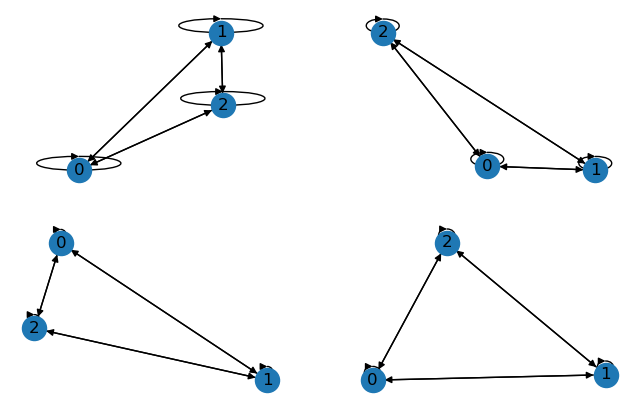

In [34]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

i = 0
j = 0 
for pmat in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        ax = axes[j//2][j%2]
        G = nx.DiGraph(pmat)
        nx.draw(G, with_labels=True, ax=ax)
        j += 1
    i += 1

plt.show()